## 『本次練習內容』
#### 搭建一個能識別驗證碼的模型(CNN+CTC)

## 『本次練習目的』
  #### 了解如何結合CNN與CTC Loss
  #### 有時間學員也可以延伸閱讀CNN+RNN+CTC模型
  #### 沒有GPU的學員可以使用Colab，可以參考問答區的文章

In [1]:
## 使用Colab可先run這裡的code
#假如要連結自己的雲端硬碟再開啟
##from google.colab import drive
##drive.mount('/content/gdrive')
#檢查GPU
##!nvidia-smi
##安裝產生驗證碼的套件

## 記得先 pip install captcha

In [2]:
##!pip install captcha

## 產生驗證碼

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ


Text(0.5, 1.0, 'EX2Z')

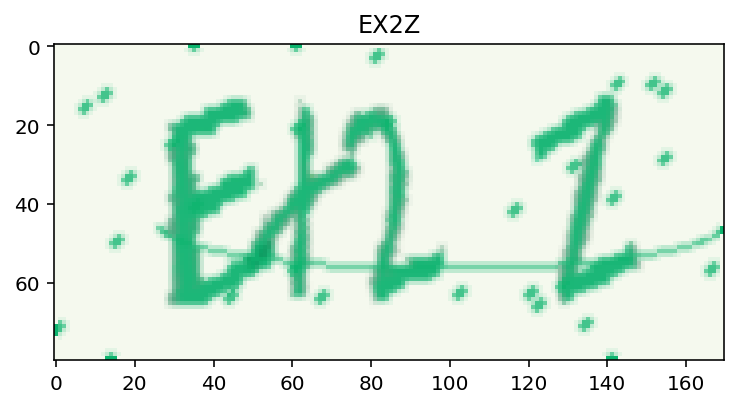

In [3]:
from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
##驗證碼包含0-10數字以及26個英文字母
characters = string.digits + string.ascii_uppercase
print(characters)

##設定產生圖片尺寸，以及總類別，n_class之所以要加一是為了留一個位置給Blank
width, height, n_len, n_class = 170, 80, 4, len(characters)+1

##設定產生驗證碼的generator
generator = ImageCaptcha(width=width, height=height)

##我們先練習固定長度4個字的驗證碼
random_str = ''.join([random.choice(characters) for j in range(4)])
img = generator.generate_image(random_str)

plt.imshow(img)
plt.title(random_str)

## 自己搭建一個CNN模型使得output feature Map 高度被壓縮成小於4，8<寬度<20
#### 解答的output feature Map 為 (batch_size,1,13,32)

In [4]:
from keras import backend as K
import keras

##CTC Loss需要四個資訊，分別是
## Label
## 預測
## CNN OUTPUT寬度
## 預測影像所包含文字長度
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

Using TensorFlow backend.


In [5]:
from keras.models import *
from keras.layers import *
from keras.layers import LeakyReLU
rnn_size = 128

input_tensor = Input((height,width, 3))
x = input_tensor

for i in range(4):
    x = Conv2D(64*(i+1), 3, activation=LeakyReLU(alpha=0.1))(x)
    x = Conv2D(64*(i+1), 3, activation=LeakyReLU(alpha=0.1))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)



##記錄輸出CNN尺寸，loss部分需要這個資訊
##conv_shape=(Batch_size,輸出高度,輸出寬度,輸出深度)
conv_shape = x.get_shape()

##從(Batch_size,輸出高度,輸出寬度,輸出深度)變成(Batch_size,輸出寬度,輸出深度*輸出高度)，以符合ctc loss需求
x = Reshape(target_shape=(int(conv_shape[2]), int(conv_shape[1]*conv_shape[3])))(x)

x = Dense(64, activation='relu')(x)

x = Dropout(0.25)(x)
x = Dense(n_class, activation='softmax')(x)


##包裝用來預測的model
base_model = Model(input=input_tensor, output=x)


##設定要給CTC Loss的資訊
labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), 
                  name='ctc')([x, labels, input_length, label_length])

##這裡的model是用來計算loss
model = Model(input=[input_tensor, labels, input_length, label_length], output=[loss_out])

##之所以要lambda y_true, y_pred: y_pred是因為我們的loss已經包在網路裡，會output:y_true, y_pred，而我們只需要y_pred
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='sgd')

/home/yanroo/anaconda3/envs/Keras/lib/python3.6/site-packages/keras/activations.py:235: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



/home/yanroo/anaconda3/envs/Keras/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/home/yanroo/anaconda3/envs/Keras/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


In [6]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 80, 170, 3)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 78, 168, 64)  1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 76, 166, 64)  36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 76, 166, 64)  256         conv2d_2[0][0]                   
____________________________________________________________________________________________

In [7]:
##設計generator產生training data
## 產生包含要給loss的資訊
## X=輸入影像
## np.ones(batch_size)*int(conv_shape[2])=CNN輸出feature Map寬度
## np.ones(batch_size)*n_len=字串長度(可浮動)

def gen(batch_size=128):
    X = np.zeros((batch_size,height, width, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.uint8)
    while True:
        generator = ImageCaptcha(width=width, height=height)
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            X[i] = np.array(generator.generate_image(random_str))
            y[i] = [characters.find(x) for x in random_str]
        yield [X, y,np.ones(batch_size)*int(conv_shape[2]), np.ones(batch_size)*n_len], np.ones(batch_size)

Label:  [[22 29 11 22]]
CNN輸出寬度:  [6.]
字串長度(可浮動):  [4.]


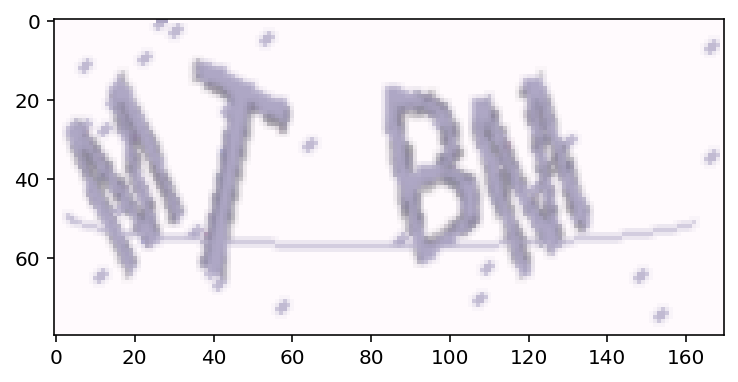

In [8]:
next_ge=gen(batch_size=1)
test_ge=next(next_ge)
plt.imshow(test_ge[0][0][0])
print('Label: ',test_ge[0][1])
print('CNN輸出寬度: ',test_ge[0][2])
print('字串長度(可浮動): ',test_ge[0][3])

## 開始訓練

In [9]:
model.fit_generator(gen(32), steps_per_epoch=300, epochs=60)

Epoch 1/60
300/300 [==============================] - 32s 108ms/step - loss: 11.1115
Epoch 2/60
300/300 [==============================] - 31s 104ms/step - loss: 6.5918
Epoch 3/60
300/300 [==============================] - 31s 102ms/step - loss: inf
Epoch 4/60
300/300 [==============================] - 30s 101ms/step - loss: inf
Epoch 5/60
300/300 [==============================] - 31s 103ms/step - loss: 4.4746
Epoch 6/60
300/300 [==============================] - 31s 103ms/step - loss: 4.1287
Epoch 7/60
300/300 [==============================] - 30s 101ms/step - loss: 3.9593
Epoch 8/60
300/300 [==============================] - 31s 103ms/step - loss: 3.6783
Epoch 9/60
300/300 [==============================] - 31s 102ms/step - loss: 3.4417
Epoch 10/60
300/300 [==============================] - 31s 103ms/step - loss: 3.3465
Epoch 11/60
300/300 [==============================] - 31s 102ms/step - loss: 3.2088
Epoch 12/60
300/300 [==============================] - 31s 104ms/step - loss: i

## 預測

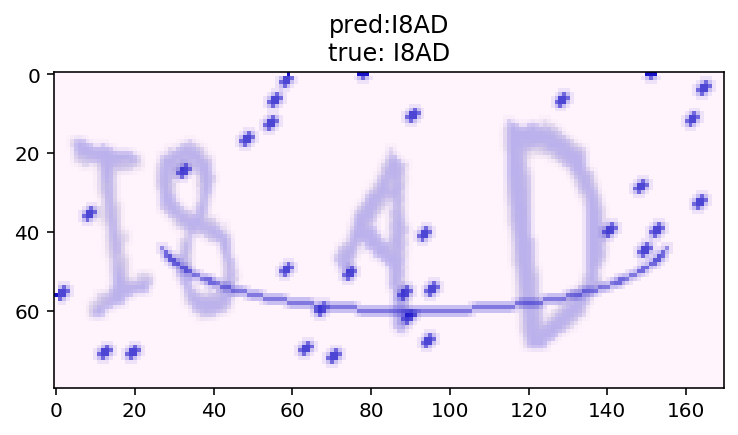

In [10]:
characters2 = characters + ' '
[X_test, y_test, _, _], _  = next(gen(1))
y_pred = base_model.predict(X_test)
##用ctc_decode得到解答，自己寫可以參考下方
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])
out = ''.join([characters[x] for x in out[0]])
y_true = ''.join([characters[x] for x in y_test[0]])

plt.imshow(X_test[0])
plt.title('pred:' + str(out) + '\ntrue: ' + str(y_true))

argmax = np.argmax(y_pred, axis=2)[0]

In [11]:
correct = 0
for i in range(100):
    [X_test, y_test, _, _], _  = next(gen(1))
    y_pred = base_model.predict(X_test)
    ##用ctc_decode得到解答，自己寫可以參考下方
    out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])
    out = ''.join([characters[x] for x in out[0]])
    y_true = ''.join([characters[x] for x in y_test[0]])
    if y_true == out:
        correct += 1



print("Accuracy: ", correct/100)

Accuracy:  0.63


## 自己寫 decode CTC

In [12]:
## 其中0代表預測為空格，如果預測相同字符之間沒有空格要移除
word=''
n=''
for single_result in y_pred[0].argmax(1):
    if single_result != 36:
        if n != single_result:
            word+=characters[single_result]
    n=single_result 

## 額外參考：加入RNN的神經網路

In [13]:
from keras.models import *
from keras.layers import *
rnn_size = 128

input_tensor = Input((height,width, 3))
x = input_tensor
for i in range(4):
    x = Conv2D(32, 3, activation='relu')(x)
    x = keras.layers.BatchNormalization(axis=-1)(x)
    x = Conv2D(32, 3, activation='relu')(x)
    x = keras.layers.BatchNormalization(axis=-1)(x)
    if i <3:
        x = MaxPooling2D(pool_size=(2, 2))(x)
    else:
        x = MaxPooling2D(pool_size=(2, 1))(x)


conv_shape = x.get_shape()
x = Reshape(target_shape=(int(conv_shape[2]), int(conv_shape[1]*conv_shape[3])))(x)

x = Dense(32, activation='relu')(x)

gru_1 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, 
             init='he_normal', name='gru1_b')(x)
gru1_merged = keras.layers.add([gru_1, gru_1b])

gru_2 = GRU(rnn_size, return_sequences=True, init='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, 
             init='he_normal', name='gru2_b')(gru1_merged)
x = keras.layers.Concatenate()([gru_2, gru_2b])

x = Dropout(0.25)(x)
x = Dense(n_class, init='he_normal', activation='softmax')(x)

base_model = Model(input=input_tensor, output=x)

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), 
                  name='ctc')([x, labels, input_length, label_length])

model = Model(input=[input_tensor, labels, input_length, label_length], output=[loss_out])
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='Adam')

/home/yanroo/anaconda3/envs/Keras/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, name="gru1", kernel_initializer="he_normal")`
/home/yanroo/anaconda3/envs/Keras/lib/python3.6/site-packages/ipykernel_launcher.py:25: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, go_backwards=True, name="gru1_b", kernel_initializer="he_normal")`
/home/yanroo/anaconda3/envs/Keras/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, name="gru2", kernel_initializer="he_normal")`
/home/yanroo/anaconda3/envs/Keras/lib/python3.6/site-packages/ipykernel_launcher.py:30: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(128, return_sequences=True, go_backwards=True, name="gru2_b", kernel_initializer="he_normal")`
/home/yanroo/anaconda3/envs/Keras/lib/python3.6/site-packages/ipyk

In [14]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 80, 170, 3)   0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 78, 168, 32)  896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 78, 168, 32)  128         conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 76, 166, 32)  9248        batch_normalization_5[0][0]      
____________________________________________________________________________________________

In [15]:
model.fit_generator(gen(32), steps_per_epoch=300, epochs=60)

Epoch 1/60
300/300 [==============================] - 39s 130ms/step - loss: 14.9373
Epoch 2/60
300/300 [==============================] - 33s 110ms/step - loss: 5.5819
Epoch 3/60
300/300 [==============================] - 33s 111ms/step - loss: 2.9023
Epoch 4/60
300/300 [==============================] - 33s 110ms/step - loss: 2.1677
Epoch 5/60
300/300 [==============================] - 33s 109ms/step - loss: 1.7798
Epoch 6/60
300/300 [==============================] - 34s 112ms/step - loss: 1.5107
Epoch 7/60
300/300 [==============================] - 33s 110ms/step - loss: 1.3612
Epoch 8/60
300/300 [==============================] - 33s 109ms/step - loss: 1.1976
Epoch 9/60
300/300 [==============================] - 34s 112ms/step - loss: 1.0966
Epoch 10/60
300/300 [==============================] - 33s 111ms/step - loss: 1.0632
Epoch 11/60
300/300 [==============================] - 33s 110ms/step - loss: 0.9686
Epoch 12/60
300/300 [==============================] - 33s 109ms/step - l

In [16]:
correct = 0
for i in range(100):
    [X_test, y_test, _, _], _  = next(gen(1))
    y_pred = base_model.predict(X_test)
    ##用ctc_decode得到解答，自己寫可以參考下方
    out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])
    out = ''.join([characters[x] for x in out[0]])
    y_true = ''.join([characters[x] for x in y_test[0]])
    if y_true == out:
        correct += 1



print("Accuracy: ", correct/100)

Accuracy:  0.22
